In [1]:
#Lambda = 1 - alpha*(1 - exp(1)^(1beta*t))


In [2]:
library(ape)
library(phangorn)

In [3]:
tr <- rtree(10)

In [4]:
aln1 <- as.DNAbin(simSeq(tr))

In [5]:
aln1

10 DNA sequences in binary format stored in a matrix.

All sequences of same length: 1000 

Labels: t9 t3 t10 t5 t7 t8 ...

Base composition:
    a     c     g     t 
0.250 0.251 0.252 0.247 

In [6]:
aln12 <- aln1[, -seq(from = 3, to = ncol(aln1), by = 3)]

In [7]:
aln12

10 DNA sequences in binary format stored in a matrix.

All sequences of same length: 667 

Labels: t9 t3 t10 t5 t7 t8 ...

Base composition:
    a     c     g     t 
0.250 0.249 0.251 0.250 

In [12]:
tr <- rtree(10)
tr12 <- tr
tr12$edge.length <- runif(length(tr$edge.length))
tr3 <- tr
tr3$edge.length <- runif(length(tr$edge.length))

tr_divided <- tr
tr_divided$edge.length <- tr12$edge.length / tr3$edge.length

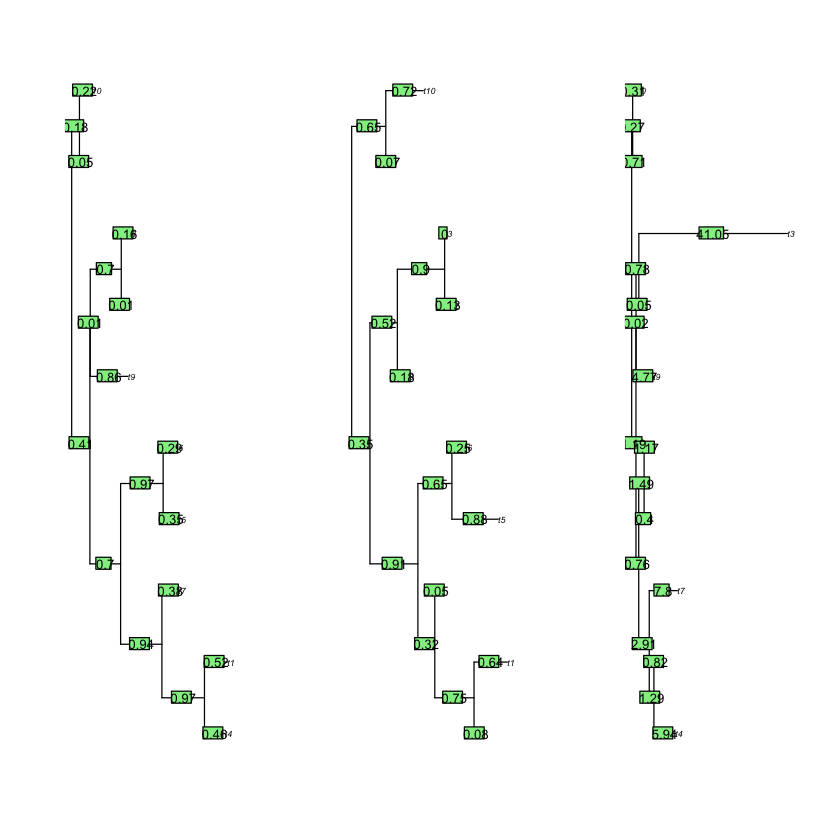

In [15]:
par(mfrow = c(1, 3))
plot(tr12)
edgelabels(round(tr12$edge.length, 2))
plot(tr3)
edgelabels(round(tr3$edge.length, 2))
plot(tr_divided)
edgelabels(round(tr_divided$edge.length, 2))

In [42]:
er_fit_decay <- function(data, par){
    rate <- data$rate
    time <- data$time
    alpha <- par[1]
    beta <- par[2]
    rate_fit <- (1 - alpha*(1-exp(1)^(-beta*time)  ))
    return(sum(abs(rate - rate_fit)^2))
}

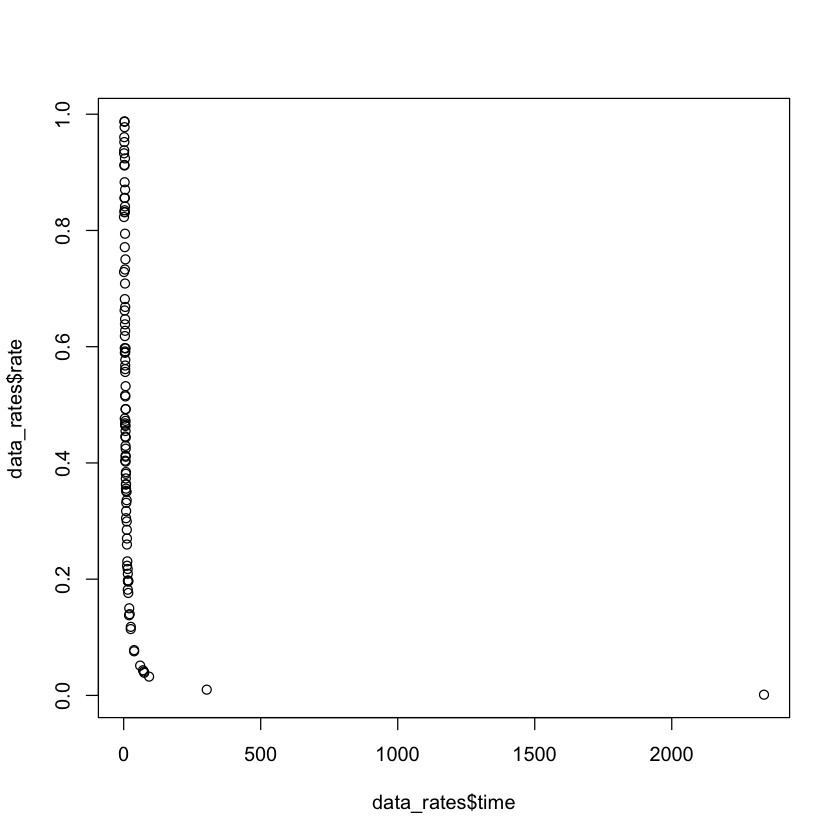

In [79]:
rate <- runif(100)
time <- (3/rate) + rnorm(100)
data_rates <- data.frame(rate=rate, time = time)
plot(data_rates$time, data_rates$rate)
points(sort(time), fit_times, col = 'red')

In [72]:
result <- optim(par = c(0, 1), er_fit_decay, data = data_rates)

In [73]:
result

ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[5]]) result is length 0


$par
[1] 0.99474863 0.09820518

$value
[1] 1.11425

$counts
function gradient 
     101       NA 

$convergence
[1] 0

$message
NULL


In [82]:
rate_curve <- function(time) (1 -0.99*(1-exp(1)^(-0.09*time)))

In [83]:
fit_times <- rate_curve(sort(time))

ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[5]]) result is length 0


$par
[1] 0.9784898 0.2991922

$value
[1] 0.1409788

$counts
function gradient 
     109       NA 

$convergence
[1] 0

$message
NULL


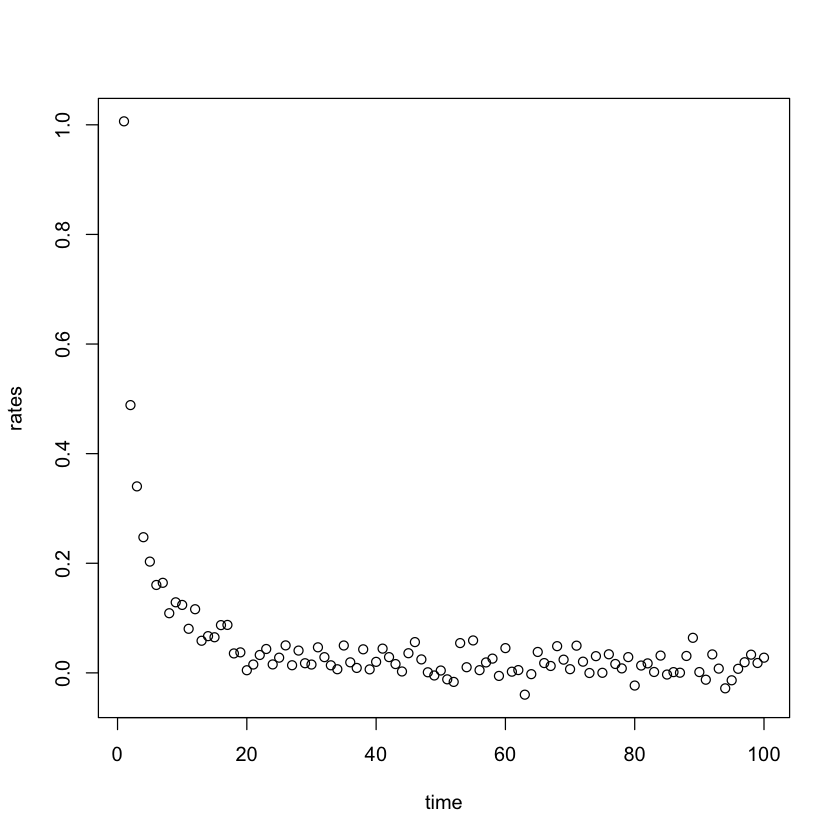

In [97]:
time <- 1:100
rates <- 1/time + rnorm(100, 0, 0.02)
plot(time, rates)

data_rates <- data.frame(time, rates)
result <- optim(par = c(0, 1), er_fit_decay, data = data_rates)
result

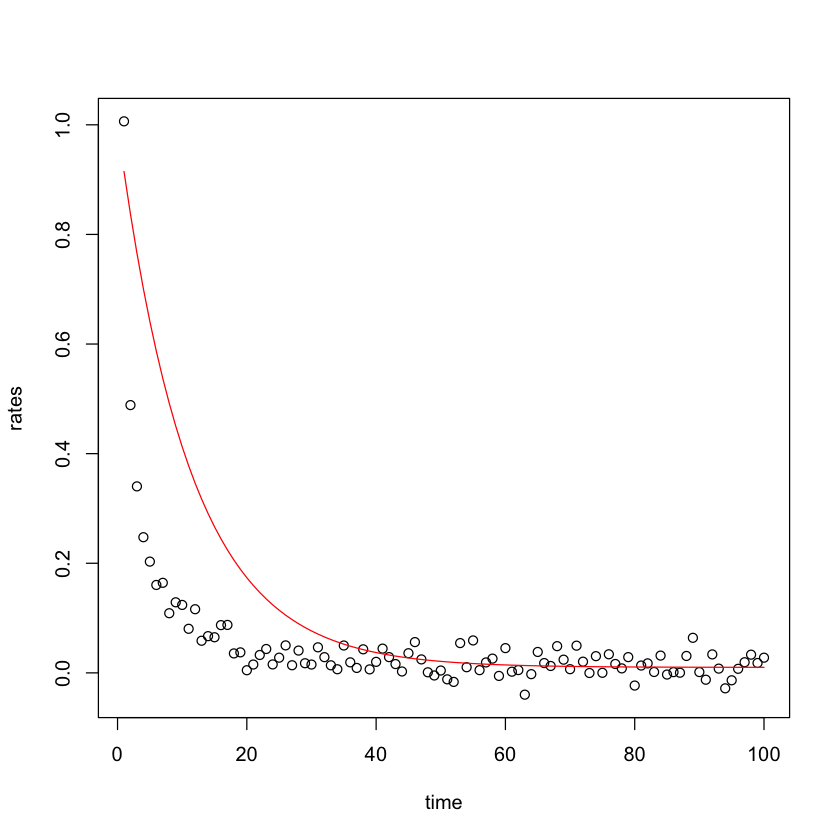

In [177]:
#fit_rates <- rate_curve(time)
#plot(time, fit_rates, col = 'red')
rate_curve <- function(time) (1 -0.99*(1-exp(1)^(-0.29*time)))
fit_times <- rate_curve(sort(time))
dat_ <- data.frame(time = fit_times, rate = sort(time))
plot(time, rates)
lines(sort(time), fit_rates, col = 'red')

In [178]:
sapply(1:100, function(x) runif(1)>0.5)

[1] FALSE  TRUE FALSE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE FALSE FALSE FALSE
 [13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE
 [25] FALSE FALSE FALSE  TRUE FALSE FALSE  TRUE  TRUE FALSE FALSE  TRUE  TRUE
 [37] FALSE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [49]  TRUE FALSE FALSE FALSE  TRUE FALSE FALSE  TRUE  TRUE  TRUE  TRUE FALSE
 [61] FALSE  TRUE FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE  TRUE FALSE  TRUE
 [73]  TRUE FALSE  TRUE FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE
 [85] FALSE  TRUE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE FALSE  TRUE
 [97] FALSE  TRUE FALSE  TRUE

In [339]:
er_fit_decay <- function(data, par){
    rate <- data$rate
    time <- data$time
    alpha <- par[1]
    beta <- par[2]
    rate_fit <- (1 - alpha*(1-exp(1)^(-beta*time)  ))
    return(log(mean((rate - rate_fit))^2))
}
er_fit_decay(data_rates, c(0, 1))
get_prior(c(0, 1))


[1] -0.1036582

[1] -2.337877

In [430]:
# Code mcmc
params_prev <- c(0, 0)
out_frame <- data.frame(step = 1:50000, likelihood = rep(NA, 1000), prior = rep(NA, 1000)
                        ,posterior = rep(NA, 1000), alpha = rep(NA, 1000),
                       beta = rep(NA, 1000))
get_prior <- function(par) log(dnorm(par[1], mean = 1, sd = 10))+log(dnorm(par[2], mean = 1, 
                                                                         sd = 10))

prior_1 <- get_prior(params_prev)
likelihood_1 <- er_fit_decay(data_rates, params_prev)
posterior_1 <- prior_1 + likelihood_1

out_frame[1,2:6] <- c(likelihood_1, prior_1, posterior_1, params_prev)
head(out_frame)

,step,likelihood,prior,posterior,alpha,beta
1,1,-0.1090256,-6.453047,-6.562073,0,0
2,2,NA,NA,NA,NA,NA
3,3,NA,NA,NA,NA,NA
4,4,NA,NA,NA,NA,NA
5,5,NA,NA,NA,NA,NA
6,6,NA,NA,NA,NA,NA


In [431]:
ac_tally <- 0
re_tally <- 0
for(i in 2:nrow(out_frame)){
#    print(i)
    params_temp <- params_prev + rnorm(2, mean=0, sd = .2)
    likelihood_temp <- -er_fit_decay(data = data_rates, par = params_temp)
    prior_temp <- get_prior(params_temp)
    posterior_temp <- likelihood_temp + prior_temp

    if(any(c(prior_temp, posterior_temp, likelihood_temp)==Inf)) next
    if(any(c(prior_temp, posterior_temp, likelihood_temp)==-Inf)) next

    if(runif(1) < exp(posterior_temp )){
        ac_tally <- ac_tally+1
        out_frame[i, 2:6] <- c(likelihood_temp, prior_temp, posterior_temp, params_temp)
    }else{
        out_frame[i, 2:6] <- out_frame[i-1, 2:6]
        re_tally <- re_tally+1
    }
        
    }


In [432]:
head(out_frame)

,step,likelihood,prior,posterior,alpha,beta
1,1,-0.1090256,-6.453047,-6.562073,0,0
2,2,-0.1090256,-6.453047,-6.562073,0,0
3,3,-0.1090256,-6.453047,-6.562073,0,0
4,4,-0.1090256,-6.453047,-6.562073,0,0
5,5,-0.1090256,-6.453047,-6.562073,0,0
6,6,-0.1090256,-6.453047,-6.562073,0,0


In [433]:
ac_tally

[1] 172

[1] 49827

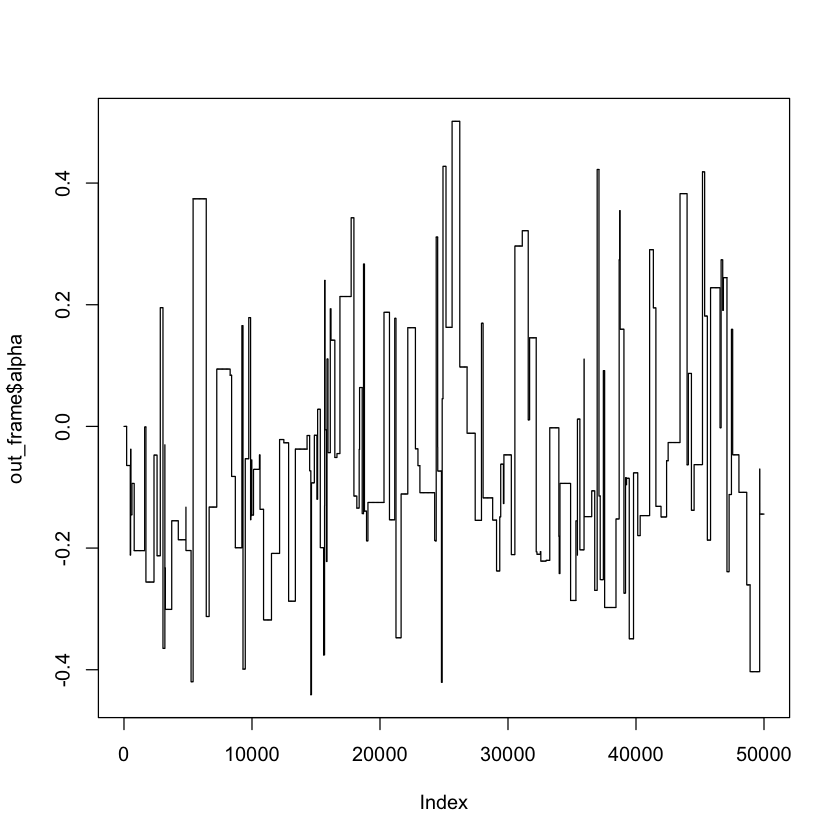

In [434]:
re_tally
plot(out_frame$alpha, type = 'l')

In [435]:
sapply(1:ncol(out_frame), function(x) mean(out_frame[, x]))

[1]  2.500050e+04  4.192268e+00 -6.453513e+00 -2.261244e+00 -5.052348e-02
[6]  3.150370e-02

In [436]:
colnames(out_frame)

[1] "step"       "likelihood" "prior"      "posterior"  "alpha"     
[6] "beta"

ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[5]]) result is length 0


$par
[1] 0.9497227 1.2538520

$value
[1] -81.94594

$counts
function gradient 
     273       NA 

$convergence
[1] 0

$message
NULL


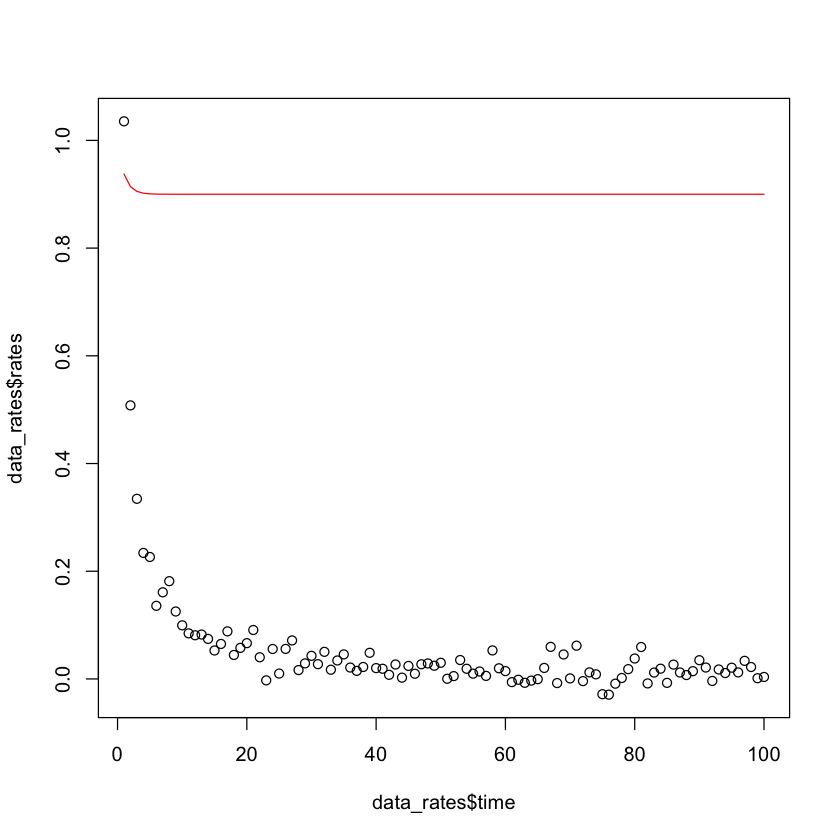

In [437]:
time <- 1:100
rates <- 1/time + rnorm(100, 0, 0.02)
rate_curve <- function(time) (1 -(0.1)*(1-exp(1)^(-0.98*time)))
fit_times <- rate_curve(sort(data_rates$time))
plot(data_rates$time, data_rates$rates)
lines(sort(data_rates$time), fit_times, col = 'red')

data_rates <- data.frame(time, rates)
result <- optim(par = c(0, 1), er_fit_decay, data = data_rates)
result

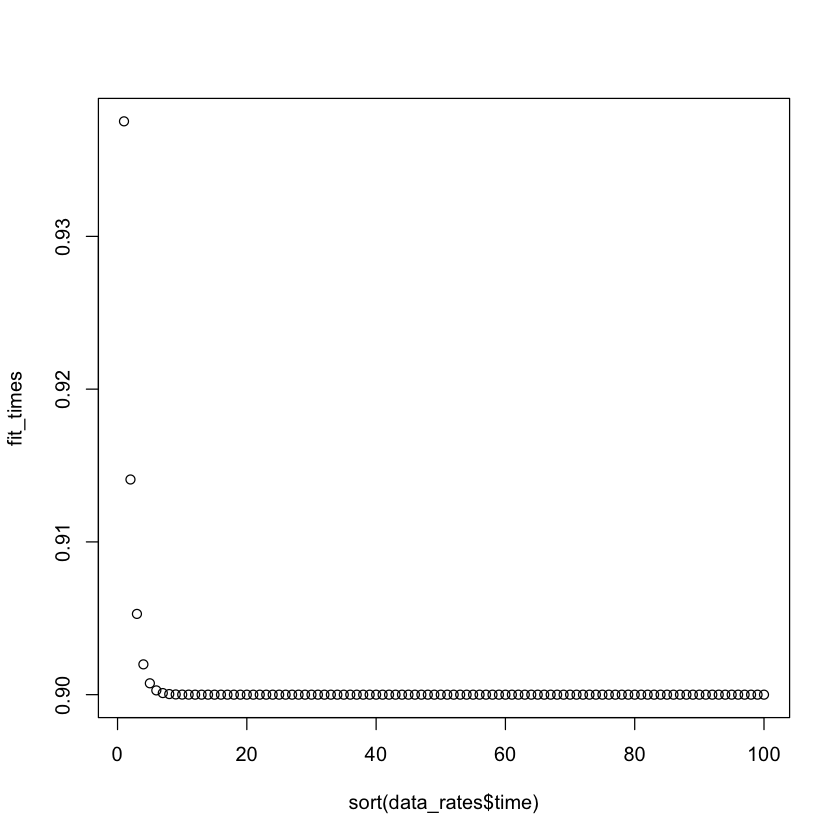

In [428]:
plot(sort(data_rates$time), fit_times)